In [19]:
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from nltk import sent_tokenize,word_tokenize
from string import punctuation
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm
from sklearn.svm import SVC, LinearSVC, LinearSVR
import re
from nltk.stem import WordNetLemmatizer
import nltk
import math
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from nltk.corpus import wordnet
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score

In [2]:


def distance(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))/1000

In [3]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20201281" #@param {type:"string"}
Student_full_name = "Aziz AOUDJIT" #@param {type:"string"}
#@markdown ---

In [4]:
def similarity(listWords):
    result=[]
    for word1 in listWords.values:
        for word2 in listWords.values:
            print(word1)
            wordFromList1 = wordnet.synsets(word1)
            wordFromList2 = wordnet.synsets(word2)
            if wordFromList1 and wordFromList2: 
                s = wordFromList1[0].wup_similarity(wordFromList2[0])
                if s>0.70 and s!=1.0:
                    print(s)
                    listWords.remove(word2)
    return listWords

In [5]:
def distanceEncoder(distance):
    try:
        if distance<5 : 
            return "urban"
        if distance<10 :
            return "outurban"
        if distance<20 : 
            return "extraouturban"
        if distance>=20 :
            return "farest"
    except:
        return 

In [6]:
class NlpPipeline():
    def __init__(self, data, excluded_words):
        self.data = data 
        self.excluded_words= excluded_words
        
    def tokenize(self,raw):
        tokens = []
        for sent in sent_tokenize(raw):
            sent=sent.lower()
            sent=sent.replace('-','')
            sub_tokens=word_tokenize(sent)
            for w in sub_tokens:
                tokens.append(''.join(w))
        #print(tokens)
        stopwords_en = set(stopwords.words('english'))
        #words = [word for word in tokens]
        words=[word for word in tokens if word not in stopwords_en ]
        words=[word for word in words if not re.search("^\(|\)$", word)   ]
        words=[word for word in words if  not re.search("[0-9].[0-9]+[m]|[0-9]+[m]", word)]
        words=[word for word in words if  not re.search("^[0-9]+[a-z]*", word)]
        words=[word for word in words if  len(word)>=4]
        #print(words)
        
        stopwords_en_with_punct=stopwords_en.union(set(punctuation))
        words=[word for word in words if word not in stopwords_en_with_punct ]
        words=[word for word in words if word not in self.excluded_words ]
        
        return words
    
    def stem(self,tokens):
        stopwords_en = set(stopwords.words('english'))
        stemmer=PorterStemmer()
        stemmize_words=[]
        for word in tokens:
            stem = stemmer.stem(word)
            if stem not in stopwords_en and  stem not in self.excluded_words and len(stem)>=4:
                stemmize_words.append(stem)
        return stemmize_words
        
    def lemmatize(self,tokens):
        lemmatize_words=[]
        lemmatizer=WordNetLemmatizer()
        for word in tokens:
            lemmatize_words.append(lemmatizer.lemmatize(word))
        return lemmatize_words
    
    def PosTag(self,tokens):
        tagged_words=nltk.pos_tag(tokens)
        return tagged_words

        
    def ner(self,tagged_words):
        chunk_words=nltk.ne_chunk(tagged_words, binary=True)
        entity_names=[]
        for tree in chunk_words.subtrees():
            #print(tree)
            entity_names.extend(self.extract_entity(tree))
        #print(entity_names)
        return entity_names
    
    def extract_entity(self,t):
        entity_names=[]
        if hasattr(t,'label') and t.label():
            if t.label()=='S':
            
               for child in t:
                   # if child[1]=='JJS' or child[1]=='JJR' or child[1]=='JJ' or child[1]=='NN':
                        entity_names.append(''.join(child[0]))
                   # else:
                      #  for child in t:
                          #  entity_names.extend(self.extract_entity(child))
            else:
                for child in t:
                    entity_names.extend(extract_entity(child))
        return entity_names
    
    def build(self):
        models = []
        data=self.data.values.reshape(-1,1)
        #print(self.data.shape)
        for i in range(data.shape[0]):
            sent=data[i]
            tokens=self.tokenize(sent[0])
            
            tokens=self.stem(tokens)
            
            tokens=self.lemmatize(tokens)
           # tokens= ' '.join(dict.fromkeys(str(tokens).split()))

            tagged_words=self.PosTag(tokens)
            #print(tagged_words)
            entities = self.ner(tagged_words)
            model = ''
            for token in entities:
                model = model + ' ' + token
            
            models.append(model)
            
        return models
    

In [41]:
# training dataset: 
training_file = 'HousePrice_Train.csv'
dftrain=pd.read_csv(training_file)
# test dataset: 
testing_file = 'HousePrice_Test.csv'
dftest=pd.read_csv(testing_file)


In [77]:
print(dftrain.columns)
dftrain.head(5)

Index(['Index', 'ID', 'Location', 'Num_Bathrooms', 'Num_Beds', 'BER_class',
       'Description', 'Services', 'Features', 'Latitude', 'Longitude', 'Type',
       'Surface', 'Price'],
      dtype='object')


,Index,ID,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Services,Features,Latitude,Longitude,Type,Surface,Price
0,1,12409116,Ongar,2,2,C3,DNG are delighted to present to the market no....,NaN,None,53.396659,-6.438791,apartment,67.00,195000
1,2,12320330,North Strand,1,2,D1,13 Northbrook Terrace is a charming red brick ...,NaN,Bight and Spacious interior\nNumerous original...,53.357129,-6.239779,terraced,95.97,425000
2,3,12405953,Stepaside,3,3,A3,"Welcome to No. 6 Cotter Close, an immaculately...",NaN,Special Features\nLarge rear garden\nGenerous ...,53.266468,-6.222771,semi-detached,107.00,535000
3,4,12202582,Cabinteely,1,3,E1,Welcome to 3 Sycamore Walk!\n\r\nEnjoying a pr...,NaN,Wonderful 3 bed detached bungalow. \nAccom...,53.261600,-6.166738,detached,81.00,499000
4,5,12299336,Lusk,3,4,D1,'Four Seasons' comes to the market as a wonder...,NaN,Detached Property \nDouble Glazed Windows...,53.550731,-6.121415,detached,153.00,510000


EDA

In [42]:
def outliners(feature):
    fig = plt.figure(figsize=(10,4))

    ax = fig.add_subplot(1, 2, 1)
    ax.set_title("Boxplot of " + feature)
    ax.set_xlabel(feature)
    ax.set_ylabel('Number of Applicants')
    dftrain.boxplot(column=[feature])

    plt.show()

In [43]:

coordinates = [dftrain.Latitude,dftrain.Longitude]
coordinates = pd.DataFrame(np.array(coordinates).T).add_prefix('C')
distances=np.ones(dftrain.Latitude.shape)
dublin_coordinate =[53.3498053,-6.2603097]
for i in range(coordinates.C0.shape[0]) :
    coord=[coordinates.C0[i], coordinates.C1[i]]
    d = distance(dublin_coordinate, np.array(coord))
    distances[i]=d
    #if d>25:

dftrain["Distances"] = pd.DataFrame(np.array(distances))    
dftrain["Distance"] = dftrain["Distances"].apply(distanceEncoder)
print(dftrain["Distance"])


0       extraouturban
1               urban
2            outurban
3       extraouturban
4              farest
            ...      
1633         outurban
1634         outurban
1635    extraouturban
1636            urban
1637    extraouturban
Name: Distance, Length: 1638, dtype: object


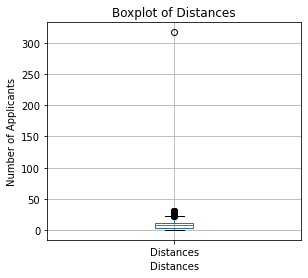

In [731]:
outliners('Distances')

In [753]:
#dftrain=dftrain[dftrain["Distances"]<50]

In [755]:

#dftrain=dftrain[dftrain['Num_Bathrooms'] < 10]


#dftrain=dftrain[dftrain['Num_Beds'] < 10]


#dftrain=dftrain[dftrain['Surface'] < 50000]

In [44]:
for i in range(dftrain.Description.values.shape[0]):
    dftrain.Description.values[i]=' '.join(dict.fromkeys(dftrain.Description.values[i].split()))
    #print (dftrain.Description.values[i])
#dftrain.Description.values = dftrain.Description.values' '.join(dict.fromkeys(string.split())))

In [45]:

dftrain.BER_class = dftrain.BER_class.replace({'A1':'excelentenergy','A2':'excelentenergy','A3':'excelentenergy'})
dftrain.BER_class = dftrain.BER_class.replace({'B1':'goodenergy','B2':'goodenergy','B3':'goodenergy'})
dftrain.BER_class = dftrain.BER_class.replace({'C1':'midiumenergy','C2':'midiumenergy','C3':'midiumenergy'})
dftrain.BER_class = dftrain.BER_class.replace({'D1':'lowenergy','D2':'lowenergy','D3':'lowenergy'})
dftrain.BER_class = dftrain.BER_class.replace({'E1':'lowerenergy','E2':'lowerenergy','E3':'lowerenergy'})
dftrain.BER_class = dftrain.BER_class.replace({'F':'badenergy','G':'badenergy','SINo666of2006exempt':'badenergy',np.nan:'badenergy'})
dftrain.Num_Beds = dftrain.Num_Beds.replace({1:'verysmall',2:'midiumsmall',3:'midiumhouse',4:'largehouse'})
dftrain.Num_Beds = dftrain.Num_Beds.replace({5:'extralarge',6:'extralarge',7:'extralarge',8:'extralarge'})
dftrain.Num_Beds = dftrain.Num_Beds.replace({9:'extralarge',15:'extralarge',27:'extralarge'})


In [46]:
dftrain["Description2"] = dftrain.Description.str.cat(dftrain.Num_Beds, sep=" ").str.cat(dftrain.BER_class, sep=" ")#.str.cat(dftrain.Distance, sep=" ")
#dftrain["Description2"] = dftrain.Num_Beds.str.cat(dftrain.BER_class, sep=" ").str.cat(dftrain.Distance, sep=" ")
dftrain["Description2"] = dftrain["Description2"].str.cat(dftrain.Type, sep=" ")

In [384]:
print(dftrain.Description2)

0       DNG are delighted to present the market no. 5 ...
1       13 Northbrook Terrace is a charming red brick ...
2       Welcome to No. 6 Cotter Close, an immaculately...
3       Welcome to 3 Sycamore Walk! Enjoying a premier...
4       'Four Seasons' comes to the market as a wonder...
                              ...                        
1633    Built in c.1930 38 Stradbrook Road is a deligh...
1634    An impressive three-story family home superbly...
1635    DNG Lucan's leading estate agents are delighte...
1636    Holyrood Castle is a most distinctive 19th cen...
1637    A superb opportunity awaits to acquire this be...
Name: Description2, Length: 1638, dtype: object


In [48]:
from sklearn.model_selection import train_test_split
y=dftrain.Price
X=dftrain
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [581]:
dftrain.isna().sum()

Index               0
ID                  0
Location            0
Num_Bathrooms       0
Num_Beds            0
BER_class           0
Description         0
Services         1061
Features            0
Latitude            0
Longitude           0
Type                0
Surface             0
Price               0
dtype: int64

In [49]:
excluded_words=['living','bedroom','Kitchen','room','bathroom','accommod',' entranc','hall','excel','delight','offer','purchas','includ','sale','agent','minut','owner','highli','four','approx','proport','sport','point','back','rear','club']
nlp = NlpPipeline (X_train.Description2,excluded_words)
data = nlp.build()
data_df = pd.DataFrame(np.array(data)).add_prefix('C')



In [50]:

print(data_df.shape)
basicvectorizer = CountVectorizer(ngram_range=(1,1),max_features=1000)
basictrain = basicvectorizer.fit_transform(data_df.C0)
print(basictrain.shape)

(1310, 1)
(1310, 1000)


In [434]:
#print(basicvectorizer.vocabulary_)

In [17]:
def calculate_mean_square_error(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.sqrt(np.mean(np.square((actual - pred) / actual))) * 100

In [51]:

basicmodel = svm.LinearSVC(C=0.1, class_weight='balanced', multi_class='ovr')
basicmodel = basicmodel.fit(basictrain, y_train)
basictrain = basicvectorizer.transform(data_df.C0)
predictions_train = basicmodel.predict(basictrain)
print ('rmspe:',calculate_mean_square_error(np.array(y_train), np.array(predictions_train)),'%')
print ('accuracy:',100-calculate_mean_square_error(np.array(y_train), np.array(predictions_train)),'%')
print ('accuracy r2:',r2_score(y_train, predictions_train)*100, '%')

rmspe: 0.0 %
accuracy: 100.0 %
accuracy r2: 100.0 %


In [52]:
nlp2 = NlpPipeline (X_test.Description2,excluded_words)
data2 = nlp2.build()
data_df2 = pd.DataFrame(np.array(data2)).add_prefix('C')

print(data_df2.shape)
print(X_test.Description2.shape)


(328, 1)
(328,)


In [53]:

basictest = basicvectorizer.transform(data_df2.C0)
predictions = basicmodel.predict(basictest)
#print (classification_report(y_test, predictions))
#print (accuracy_score(y_test, predictions))


In [54]:
from sklearn.metrics import r2_score
#print(np.array(predictions))
#print (accuracy_score(y_test, predictions))
print ('rmspe:',calculate_mean_square_error(np.array(y_test), np.array(predictions)),'%')
print ('accuracy:',100-calculate_mean_square_error(np.array(y_test), np.array(predictions)),'%')
#print(np.array([y_test,predictions]).T)
print (r2_score(y_test, predictions))
print (r2_score(y_train, predictions_train))

rmspe: 40.97679486856175 %
accuracy: 59.02320513143825 %
0.22990844370028052
1.0


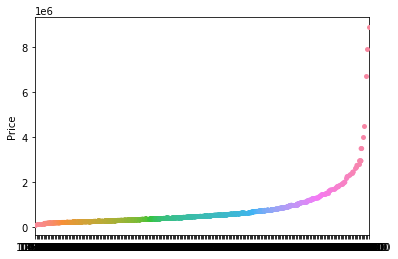

In [513]:
import seaborn as sns
sns.swarmplot(x=predictions_train,y=y_train)

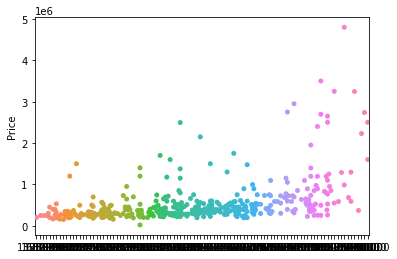

In [514]:
import seaborn as sns
sns.swarmplot(x=predictions,y=y_test)

In [341]:
def get_classification_metric(testy, probs):
    from sklearn.metrics import precision_recall_curve
    precision, recall, thresholds = precision_recall_curve(testy, probs[:,1])
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    return fscore[ix]

In [804]:
from sklearn.preprocessing import MinMaxScaler , StandardScaler
y=np.array(y_train.copy()).reshape(-1, 1)
#Scale the y - price into 0 to 1
#y=NormalizeData(y)
#y_scaller = StandardScaler()
#y=yscaler.transform(y)
print((y.T[0]))

[ 625000 1700000  315000 ...  230000  695000  500000]


In [805]:


#MNB = MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True) 
rng = np.random.RandomState(20)

MNB =  AdaBoostRegressor(DecisionTreeRegressor(max_depth=20),
                           n_estimators=5000, random_state=rng)
MNB.fit(basictrain.toarray(), (y.T[0]) ) 


#MNB = LinearSVR(random_state=0, tol=1e-5)
# fit to data
#print(basictrain.toarray(), ':', np.array(y))
#MNB.fit(basictrain, np.array(y.T[0], dtype="|S6") ) 
#MNB.fit(basictrain, (y.T[0]) ) 

#prediction_train = MNB.predict_proba(basictrain)
prediction_train = MNB.predict(basictrain.toarray())
preds = []
for i in range(prediction_train.shape[0]):
    #prob_max=np.max(prediction_train[i])
    prob_max=prediction_train[i]
    preds.append(prob_max)
#preds = np.array(preds).reshape(1,-1)
ys = []
for i in range(y.shape[0]):
    ys.append(y[i])

print('training prediction\t', len(preds),'y\t', len(ys))
print (r2_score(np.array(ys).astype(np.float64),np.array(preds).astype(np.float64)))
#print(preds)

training prediction	 1228 y	 1228
0.9928088060765048


In [579]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [810]:
y_t=np.array(y_test.copy()).reshape(-1, 1)
#Scale the y - price into 0 to 1
#y_t=NormalizeData(y_t)
#y_scaller = MinMaxScaler()
#y_t=yscaler.fit_transform(y_t)
#print((y_t.T[0]))
print(y_test.shape)

(410,)


In [812]:
#prediction_train = MNB.predict_proba(basictrain)
prediction_test = MNB.predict(basictest.toarray())
preds_test = []
for i in range(prediction_test.shape[0]):
    #prob_max=np.max(prediction_train[i])
    prob_max=prediction_test[i]
    preds_test.append(prob_max)
#preds = np.array(preds).reshape(1,-1)
yts = []
for i in range(y_t.shape[0]):
    yts.append(y_t[i])
#preds_test = NormalizeData(np.array(preds_test).astype(np.float64))
print('test prediction\t', len(preds_test),'y\t', len(y_test))
print (r2_score(yts,np.array(preds_test).astype(np.float64)))
#print (get_classification_metric(yts,preds_test))
#print(preds_test, yts)

test prediction	 410 y	 410
0.4990634375863693


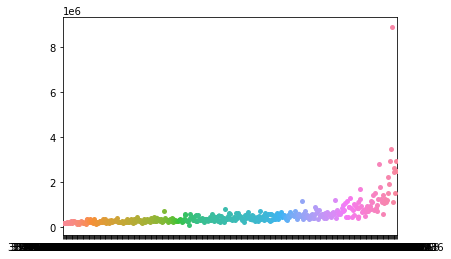

In [749]:
import seaborn as sns
sns.swarmplot(x=preds_test,y=yts)


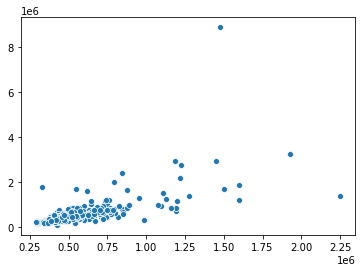

In [775]:
sns.scatterplot(x=preds_test,y=yts)

In [55]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
extra_tree = ExtraTreeRegressor(random_state=0)
reg = AdaBoostRegressor(extra_tree,n_estimators=200, random_state=0, learning_rate=0.8).fit(basictrain.toarray(), y_train)
pred_b = reg.predict(basictrain.toarray())
print (r2_score(y_train, pred_b))


0.9982027846707807


In [58]:
pred_t = reg.predict(basictest.toarray())
print (r2_score(y_test, pred_t))
print("MAE = ",(np.mean(abs(pred_t - y_test))))
print("MAPE = ",(np.mean(abs(pred_t - y_test) / y_test)))

0.6968081649370715
MAE =  126558.68902439025
MAPE =  0.22577267919806215


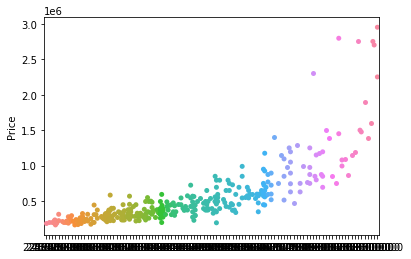

In [57]:
import seaborn as sns
sns.swarmplot(x=pred_t,y=y_test)

In [340]:
def get_classification_metric(testy, probs):
    from sklearn.metrics import precision_recall_curve
    precision, recall, thresholds = precision_recall_curve(testy, probs[:,1])
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    return fscore[ix]